In [1]:
from keras.layers import Convolution2D ,MaxPooling2D,Flatten
from keras.layers.core import Dense, Dropout, Activation
from sklearn.cross_validation import train_test_split
from keras.callbacks import History,Callback
from sklearn.metrics import classification_report
from sklearn.cross_validation import StratifiedKFold ,cross_val_score
from keras.models import model_from_config
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.regularizers import l2,activity_l2
import theano
import keras
import pickle


Using Theano backend.
Using gpu device 0: GeForce 940M (CNMeM is disabled, CuDNN not available)
C:\Users\Back_jud\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning:

downsample module has been moved to the theano.tensor.signal.pool module.



In [2]:
def cat2lab (cat): 
    '''only for binary category
    
    #Args:
    
    cat : binary categorical variable
    '''
    return np.array([0 if s[0] else 1 for s in cat])

## 1.Formatting

In [3]:
img_pickle = open('d://labels_new.p')
lab_pickle = open('d://images_new.p')
labels = np.array(pickle.load(img_pickle))
imgs = np.array(pickle.load(lab_pickle))
reg_imgs = imgs /255
cat_labels = np_utils.to_categorical(labels,nb_classes=2)

In [4]:
#reshape to shape (50,50)
reg_imgs_2d =[]
for img in reg_imgs:
    reg_imgs_2d.append(np.reshape(img,(50,50))) 
reg_imgs_2d = np.array(reg_imgs_2d)

In [5]:
#reshape to shape (1,50,50) for CNN
reg_imgs_3d =[]
for img in reg_imgs:
    reg_imgs_3d.append(np.reshape(img,(1,50,50)))
reg_imgs_3d = np.array(reg_imgs_3d)

In [6]:
x_tr1,x_te1,y_tr1,y_te1 = train_test_split(reg_imgs,cat_labels,test_size= 0.2,random_state= 123)
x_tr2,x_te2,y_tr2,y_te2 = train_test_split(reg_imgs_2d,cat_labels,test_size= 0.2,random_state= 123)
x_tr3,x_te3,y_tr3,y_te3 = train_test_split(reg_imgs_3d,cat_labels,test_size= 0.2,random_state= 123)
x_trn1,x_ten1,y_trn1,y_ten1 = train_test_split(reg_imgs,labels,test_size= 0.2,random_state= 123)


## 2.Modeling

### Trial #1 simple neuron

In [7]:
model1 = Sequential()
model1.add(Dense(2500, input_dim=2500,init ='uniform'))
model1.add(Activation('relu'))
model1.add(Dense(2, activation="softmax"))
model1.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,decay= 1e-6,momentum=0.1,nesterov=True))

In [8]:
%time hist1 = model1.fit(x_tr1, y_tr1, nb_epoch=300,validation_split=0.2 ,batch_size=50,show_accuracy=True,verbose=0)

Wall time: 24.6 s


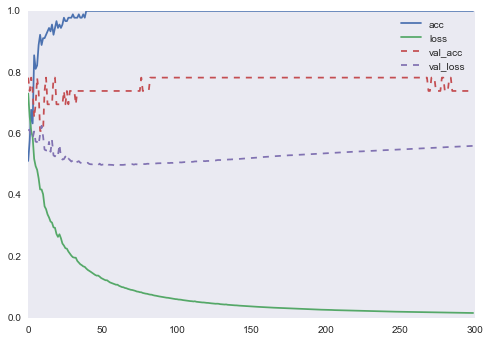

In [9]:
plt.plot(hist1.history['acc'],label='acc')
plt.plot(hist1.history['loss'],label='loss')
plt.plot(hist1.history['val_acc'],'--',label='val_acc')
plt.plot(hist1.history['val_loss'],'--',label='val_loss')
plt.grid('off')
plt.legend()

In [10]:
model1.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 2500)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 2500)                  6252500             
Activation (activation)       (None, 2500)                  0                   
Dense (dense)                 (None, 2)                     5002                
--------------------------------------------------------------------------------
Total params: 6257502
--------------------------------------------------------------------------------


In [11]:
model1.evaluate(x_te1,y_te1,batch_size=50,show_accuracy=True)

29/29 [==============================] - 0s


[0.71141541004180908, 0.72413793103448276]

In [12]:
y_pred1 = model1.predict_classes(x_te1,20)
y_pred1

29/29 [==============================] - 0s     


array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1], dtype=int64)

In [13]:
y_ten1 = cat2lab(y_te1)
y_ten1

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1])

In [14]:
print(classification_report(y_ten1,y_pred1))

             precision    recall  f1-score   support

          0       0.62      0.73      0.67        11
          1       0.81      0.72      0.76        18

avg / total       0.74      0.72      0.73        29



### Trial #2 CNN

In [15]:
model2 = Sequential()
model2.add(Convolution2D(10,10, 10, border_mode='same', input_shape=(1, 50, 50)))
model2.add(Activation('relu'))
# model2.add(Convolution2D(50, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Convolution2D(10, 10, 10,init='uniform' ,border_mode='same'))
model2.add(Activation('relu'))
# model2.add(Convolution2D(100, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.35))

model2.add(Flatten())
model2.add(Dense(1250,init='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,decay=1e-6,
                                                              momentum=0.7,
                                                              nesterov=True))

In [16]:
%time hist2 = model2.fit(x_tr3, y_tr3, nb_epoch=300 , batch_size=50 ,validation_split=0.2, show_accuracy=True ,shuffle=True,verbose =1)

Train on 90 samples, validate on 23 samples
Epoch 1/300
90/90 [==============================] - 0s - loss: 0.7323 - acc: 0.5111 - val_loss: 0.6416 - val_acc: 0.6522
Epoch 2/300
90/90 [==============================] - 0s - loss: 0.6959 - acc: 0.5333 - val_loss: 0.6367 - val_acc: 0.7826
Epoch 3/300
90/90 [==============================] - 0s - loss: 0.6132 - acc: 0.6556 - val_loss: 0.6679 - val_acc: 0.5217
Epoch 4/300
90/90 [==============================] - 0s - loss: 0.6467 - acc: 0.6000 - val_loss: 0.6060 - val_acc: 0.8261
Epoch 5/300
90/90 [==============================] - 0s - loss: 0.5709 - acc: 0.7889 - val_loss: 0.5175 - val_acc: 0.6957
Epoch 6/300
90/90 [==============================] - 0s - loss: 0.6907 - acc: 0.5444 - val_loss: 0.5110 - val_acc: 0.6957
Epoch 7/300
90/90 [==============================] - 0s - loss: 0.5787 - acc: 0.6333 - val_loss: 0.5016 - val_acc: 0.8261
Epoch 8/300
90/90 [==============================] - 0s - loss: 0.5178 - acc: 0.7778 - val_loss: 0.466

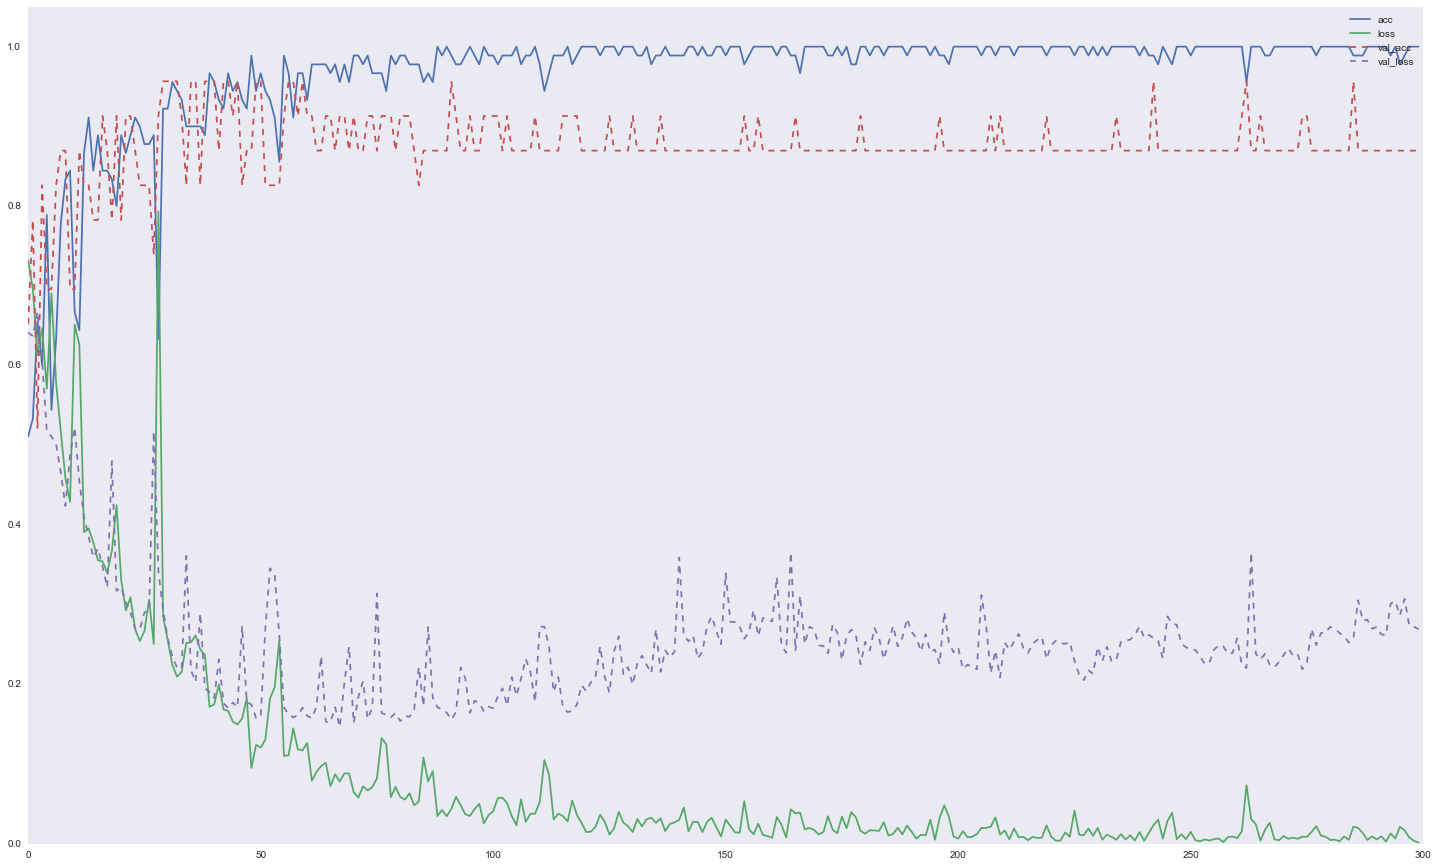

In [17]:
plt.figure(figsize=(25,15))
plt.plot(hist2.history['acc'],label='acc')
plt.plot(hist2.history['loss'],label='loss')
plt.plot(hist2.history['val_acc'],'--',label='val_acc')
plt.plot(hist2.history['val_loss'],'--',label='val_loss')
plt.legend()
plt.ylim(0,max(hist2.history['acc'])+0.05)
plt.grid('off')

In [18]:
model2.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 1, 50, 50)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Convolution2D (convolution2d) (None, 10, 50, 50)            1010                
Activation (activation)       (None, 10, 50, 50)            0                   
MaxPooling2D (maxpooling2d)   (None, 10, 25, 25)            0                   
Dropout (dropout)             (None, 10, 25, 25)            0                   
Convolution2D (convolution2d) (None, 10, 25, 25)            10010               
Activation (activation)       (None, 10, 25, 25)            0                   
MaxPooling2D (maxpooling2d)   (None, 10, 12, 12)            0                   
Dropout (dropout)             (None, 10, 12, 12)            0         

In [19]:
model2.evaluate(x_te3,y_te3,batch_size=50,show_accuracy=True,verbose=1)

29/29 [==============================] - 0s


[0.40913289785385132, 0.93103448275862066]

In [20]:
def plot_wegh (model):
    '''
    Plot weights of convolution layer
    
    #Args
    model : fitted model
    '''
    wegh_arr = model.get_weights()
    num = len(wegh_arr[0])
    if type(np.sqrt(num)) is int:
        col = np.sqrt(num)
        row = np.sqrt(num) 
    else:
        col = int(num/2)
        row = int(num/col)
        
    fig ,axes = plt.subplots(row,col, subplot_kw={'xticks': [], 'yticks': []})
    plt.subplots_adjust(hspace=0.02,wspace = 0.05)
    
    for i, ax in zip(xrange(num),axes.flat):
        
        ax.imshow(wegh_arr[0][i][0])
        ax.grid('off')
    plt.show()

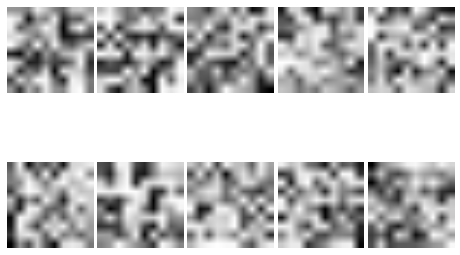

In [21]:
plot_wegh(model2)

In [22]:
y_pred2 = model2.predict_classes(x_te3)
y_pred2

29/29 [==============================] - 0s


array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [23]:
y_ten2 = cat2lab(y_te3)
y_ten2

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1])

In [24]:
print(classification_report(y_ten2,y_pred2))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90        11
          1       0.90      1.00      0.95        18

avg / total       0.94      0.93      0.93        29



### Trial #3 SVM

In [25]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

In [26]:
cv = StratifiedKFold(labels,n_folds=10,shuffle=True)

In [27]:
params = {'C' : [1e1, 1e2, 1e3,1e4,1e5],
           'gamma' : [0.0001,0.0005,0.001,0.005,0.01]}

In [28]:
clf_grid = GridSearchCV(SVC(kernel='rbf'),params,cv=cv)

In [29]:
model3 = clf_grid.fit(reg_imgs,labels)

In [32]:
model3.best_score_ , model3.best_params_

(0.88028169014084512, {'C': 10.0, 'gamma': 0.01})

In [33]:
#demostration of upper GridSearchCV method
svc_rslt = []
for x,y in cv: 
    clf = SVC(kernel='rbf',C=10.0,gamma = 0.005,)
    clf.fit(reg_imgs[x],labels[x])
    svc_rslt.append(clf.score(reg_imgs[y], labels[y]))
svc_rslt = np.array(svc_rslt)
svc_rslt

array([ 0.8       ,  0.8       ,  0.86666667,  0.86666667,  0.8       ,
        0.92857143,  0.78571429,  0.92307692,  0.84615385,  0.92307692])

In [34]:
print('cross valdated SVC score is ' , svc_rslt.mean())

cross valdated SVC score is  0.853992673993


### Trial #4 Ensenbling

In [35]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [36]:
ens1 = RandomForestClassifier(n_estimators =  250 , max_depth= None,verbose=1)

ens2 = AdaBoostClassifier(SVC(kernel='rbf',gamma=0.005,C = 10.0),
                          algorithm="SAMME",
                          n_estimators=100,
                          learning_rate=0.01)


ens3  = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None),
                         algorithm="SAMME",
                         n_estimators=100,
                          learning_rate=0.01)



In [37]:
ens1.fit(x_trn1, y_trn1)
ens2.fit(x_trn1, y_trn1)
ens3.fit(x_trn1, y_trn1)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=None)

In [38]:
ens1.score(x_ten1,y_ten1)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


0.7931034482758621

In [39]:
ens2.score(x_ten1,y_ten1)

0.62068965517241381

In [40]:
ens3.score(x_ten1,y_ten1)

0.44827586206896552

## additional trial 

### (temp) Harr-like feature

### (temp)Wavelet tranform

### (temp)Hough